In [1]:
import sys; sys.path.insert(0, '../../'); sys.path.insert(0,'../../../mac/ndtest/')
sys.path.insert(0, '../mupClassification/'); 
from mupClassification_notebooks import *
from ccqe_notebook_tools import * 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib notebook
# %matplotlib

# optimization of the box dimensions for $\frac{\Delta Q_{track}}{\Delta Q_{total}}$ 

In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mupClassification/Figures/DetectionObservables/VertexActivity/BoxOptimization/'

# pairs of 2-tracks at close proximity

In [33]:
N_r_around_vertex = 30
Min_r_around_vertex = 0
dr_around_vertex  = 0.5
r_around_vertex=[]
for i_r_around_vertex in range(N_r_around_vertex):
    r_around_vertex.append( Min_r_around_vertex + i_r_around_vertex * dr_around_vertex)

In [5]:
MCbnbDATAcosmicPairsFV, MCbnbDATAcosmicSamples = load_MCbnbDATAcosmicSamples(filename='ecohen_physical_files_adi_prodgenie_bnb_nu_uboone_overlay_cosmic_data_100K_reco2_2018_02_23_vertices')
cuts_pureff = apply_cuts_MCbnbDATAcosmic()
pureff_MCbnbDATAcosmic,pureff_MCbnbDATAcosmic_numbers = cuts_pureff
pureff_MCbnbDATAcosmic

28674 pairs from MC-BNB + cosmic DATA overlay
18908 pairs in FV
5087 are 1mu-1p, 26.9%
4335 are other pairs, 22.9%
9486 are cosmic, 50.2%
--------------------------------------------------------------
2514 are CC 1p 0pi, 13.3%


,$\mu p$ eff.,$\mu p$ pur.,CC$0\pi 1 p$ eff.,CC$0\pi 1 p$ pur.,label,1mu-1p,other pairs,cosmic,CC 1p 0pi
no cut,100.0%,26.9%,100.0%,13.3%,no cut,100.0% (5087),100.0% (4335),100.0% (9486),100.0% (2514)
PIDa,85.4%,53.6%,84.5%,26.2%,${PID}_a>13$,85.4% (4345),55.3% (2398),14.4% (1368),84.5% (2124)
flashes,85.1%,55.9%,84.2%,27.3%,$N_{flashes}>0$,85.1% (4328),55.1% (2390),10.8% (1020),84.2% (2116)
flash,80.4%,57.9%,79.3%,28.3%,optical filter,80.4% (4089),53.2% (2306),7.0% (662),79.3% (1994)
length,66.6%,67.4%,69.5%,34.7%,$l_{\mu}>l_{p}$,66.6% (3390),29.3% (1271),3.9% (370),69.5% (1746)
non-collinearity,59.7%,73.4%,64.6%,39.3%,"$|\theta_{1,2}-90^0|<55^0$",59.7% (3039),20.7% (899),2.1% (202),64.6% (1625)
vertex activity,40.7%,76.9%,55.5%,51.9%,"$\sqrt{\sum_{p=0,1,2}(R_{\Delta Q}^{p}-1)^2}<0...",40.7% (2068),11.8% (513),1.1% (107),55.5% (1395)
delta phi,27.1%,90.6%,42.5%,70.3%,$|\Delta \phi - \pi|<35^0$,27.1% (1377),2.7% (118),0.3% (25),42.5% (1069)
Pt no Delta phi,30.7%,84.9%,45.7%,62.5%,$p_{t}<0.35$ GeV/c,30.7% (1562),5.3% (229),0.5% (49),45.7% (1150)
soft Pt,23.8%,93.0%,38.2%,73.8%,$p_{t}<0.35$ GeV/c,23.8% (1210),1.7% (75),0.2% (16),38.2% (960)


# compare between 3D distributions: 
We want to find the optimal box dimensions by the ones with the largest difference (separation of CCQE from others)
in order to do that we compare between distributions using the 3D energy test

In [6]:
from scipy.spatial.distance import pdist, cdist
def Etest(x, y, method='log', epsilon=0.0001 ,debug=0):
    '''
     Energy distance statistics test.
     Reference
     ---------
     Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
       multivariate goodness-of-fit tests, two-sample comparison and unfolding.
       Nuc Instr and Meth in Phys Res A 537: 626-636
     Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
       based on distances. J Stat Planning & Infer 143: 1249-1272
     Brian Lau, multdist, https://github.com/brian-lau/multdist
     ---------
    Parameters: x: np.array()
                y:  np.array()
                method: method for energy-test function calculation
                        'log' : ln(r+ε)
                epsilon: for method 'log', this is the cutoff ε
                
    Returns:    Psi: ln(r(xy)+ε)/Nx*Ny - ln(r(xx)+ε)/Nx*Nx - ln(r(yy)+ε)/Ny*Ny
    '''
    if debug: print "energy(x, y, method='log')"
    r_xx, r_yy, r_xy = pdist(x), pdist(y), cdist(x, y)
    if debug:
        print "dx:",r_xx,'\n log(r_xx+ε):',np.log(r_xx+epsilon)
        print "r_yy:",r_yy,'\n log(r_yy+ε):',np.log(r_yy+epsilon)
        print "r_xy:",r_xy,'\n log(r_xy+ε):',np.log(r_xy+epsilon)
        
    Nx, Ny = len(x), len(y)
    
    if method == 'log':
        log_r_xx, log_r_yy, log_r_xy = np.log(r_xx+epsilon), np.log(r_yy+epsilon), np.log(r_xy+epsilon)
        Phi = log_r_xy.sum() / (Nx*Ny) - log_r_xx.sum() / (Nx*Nx) - log_r_yy.sum() / (Ny*Ny)
        
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
        
    return Phi

In [40]:
def Etest_CC1p0pi_vs_other_pair_types_per_sphere_size( samples=None, i_r_around_vertex=1 , debug=0 ):

    RdQ_xyz, RdQ_3D_array = dict(), dict()

    for i_pair_type in range(4):
        pair_type = pair_types[i_pair_type]; sample = samples[pair_type]     
        r = r_around_vertex[i_r_around_vertex]
        Ru,Rv,Ry = 'RdQaroundVertex[plane 0][r=%.1fcm]'%r,'RdQaroundVertex[plane 1][r=%.1fcm]'%r,'RdQaroundVertex[plane 2][r=%.1fcm]'%r
        sample = sample[(sample[Ru]>-0.01)&(sample[Rv]>-0.01)&(sample[Ry]>-0.01)]
        x,y,z = sample[Ru], sample[Rv], sample[Ry]
        RdQ_xyz[pair_type] = (x,y,z)
        RdQ_3D_array[pair_type] = np.array([[x_p,y_p,z_p] for x_p,y_p,z_p in zip(x,y,z)])
        if debug>1: print "created a 3D array for",pair_type
        
    PsiEtest = dict()
    for pair_type in (pair_types[0:3]):
        PsiEtest[pair_type+'/'+'CC 1p 0pi'] = Etest( RdQ_3D_array[pair_type], RdQ_3D_array['CC 1p 0pi'], debug=debug-1 )
    if debug: 
        print 'sphere radius: r=%.1fcm'%r_around_vertex[i_r_around_vertex]
        print PsiEtest
    return PsiEtest

In [39]:
debug = 1
sphere_size_indices = []
pd_Etest_results = pd.DataFrame()
for i_r_around_vertex in range(1,N_r_around_vertex):
    sphere_size_indices.append(i_r_around_vertex)
    PsiEtest = Etest_CC1p0pi_vs_other_pair_types_per_sphere_size( samples=reduced_MCbnbDATAcosmicSamples['no cut'], i_r_around_vertex=i_r_around_vertex , debug=debug )
    pd_Etest = pd.DataFrame({'sphere size':'r=%1fcm'%r_around_vertex[i_r_around_vertex]
                             ,'1mu-1p/CC 1p 0pi':PsiEtest['1mu-1p/CC 1p 0pi']
                             ,'other pairs/CC 1p 0pi':PsiEtest['other pairs/CC 1p 0pi']
                             ,'cosmic/CC 1p 0pi':PsiEtest['cosmic/CC 1p 0pi']}
                            ,index=[i_r_around_vertex])
    pd_Etest_results = pd_Etest_results.append(pd_Etest)
    
pd_Etest_results

len(sample): 5087
len(sample): 3335
len(sample): 4335
len(sample): 2746
len(sample): 9486
len(sample): 6014
len(sample): 2514
len(sample): 1768
sphere radius: r=0.5cm
{'1mu-1p/CC 1p 0pi': 0.01327136488297187, 'other pairs/CC 1p 0pi': 0.010067204874119828, 'cosmic/CC 1p 0pi': 0.032625859594449969}
len(sample): 5087
len(sample): 4125
len(sample): 4335
len(sample): 3400
len(sample): 9486
len(sample): 7911
len(sample): 2514
len(sample): 2089
sphere radius: r=1.0cm
{'1mu-1p/CC 1p 0pi': 0.023696233578612502, 'other pairs/CC 1p 0pi': 0.0028590327742644694, 'cosmic/CC 1p 0pi': 0.0028055587865430942}
len(sample): 5087
len(sample): 4291
len(sample): 4335
len(sample): 3584
len(sample): 9486
len(sample): 8346
len(sample): 2514
len(sample): 2169
sphere radius: r=1.5cm
{'1mu-1p/CC 1p 0pi': 0.030307360898510938, 'other pairs/CC 1p 0pi': 0.0087137793464221458, 'cosmic/CC 1p 0pi': 0.0078562815402120068}
len(sample): 5087
len(sample): 4440
len(sample): 4335
len(sample): 3729
len(sample): 9486
len(sample

,1mu-1p/CC 1p 0pi,cosmic/CC 1p 0pi,other pairs/CC 1p 0pi,sphere size
1,0.013271,0.032626,0.010067,r=0.500000cm
2,0.023696,0.002806,0.002859,r=1.000000cm
3,0.030307,0.007856,0.008714,r=1.500000cm
4,0.037318,0.020285,0.017071,r=2.000000cm
5,0.043234,0.034155,0.026383,r=2.500000cm
6,0.047659,0.047938,0.036359,r=3.000000cm
7,0.051043,0.061336,0.044520,r=3.500000cm
8,0.052118,0.069616,0.049578,r=4.000000cm
9,0.053079,0.077501,0.054590,r=4.500000cm
10,0.053109,0.086156,0.059316,r=5.000000cm


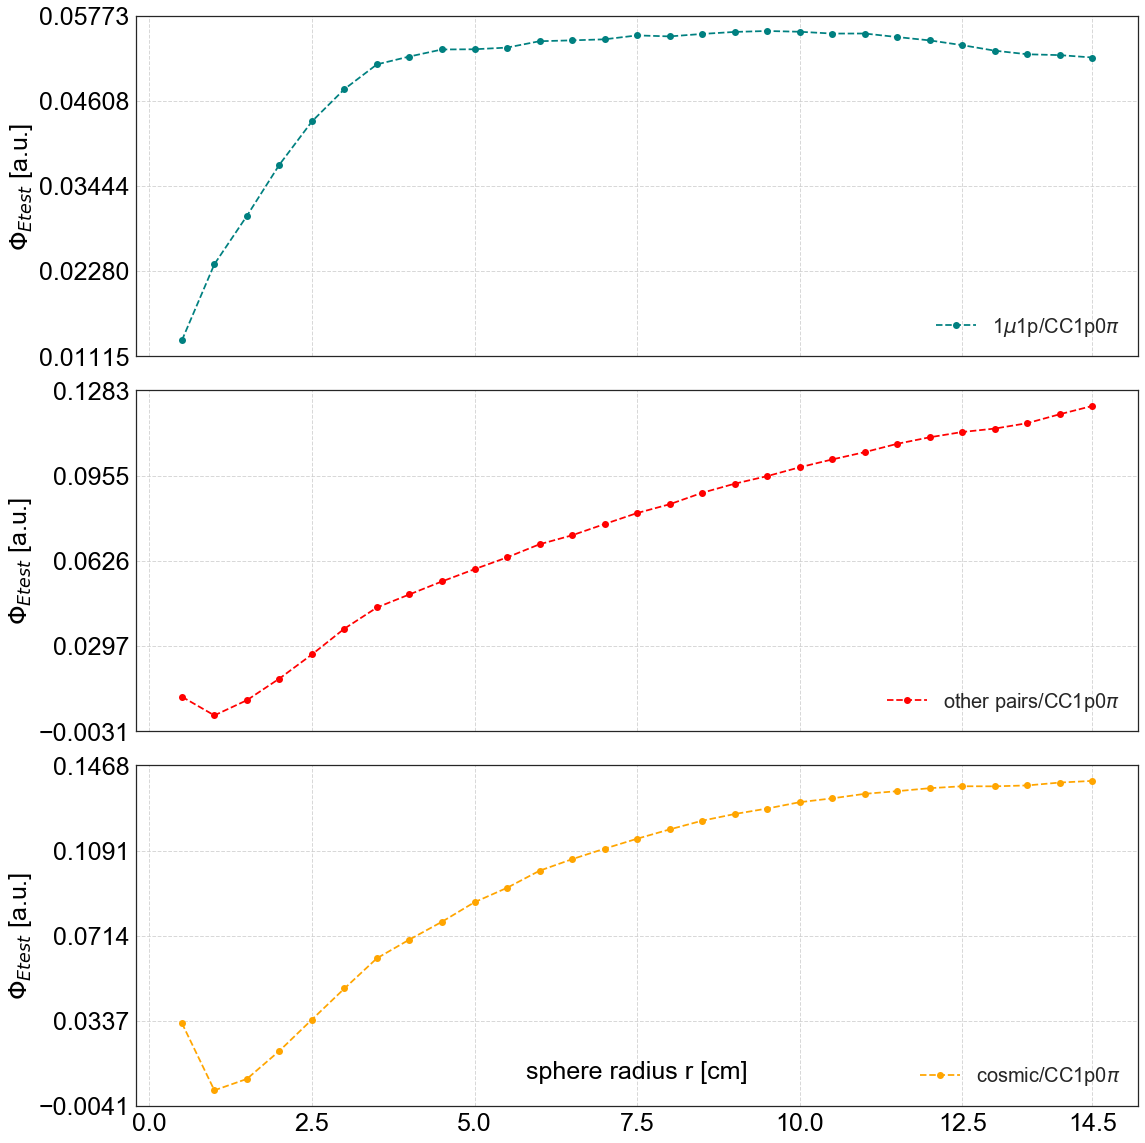

In [48]:
xticks=[0,5,10,15,20,25,29] 
fig=plt.figure(figsize=(16,16))
for i_pair_type in range(3):
    ax = fig.add_subplot(3,1,i_pair_type+1)
    pair_type=pair_types[i_pair_type];color=MCcolors[i_pair_type];label=MClabels[i_pair_type]
    y = pd_Etest_results[pair_type+'/'+'CC 1p 0pi'];
    plt.plot( y , '--o' , color=color , label=label+'/CC1p0$\pi$')
    leg=plt.legend(fontsize=20,loc='lower right')#,bbox_to_anchor=(1.05,1),loc=2
    set_axes( ax , 'sphere radius r [cm]' if i_pair_type==2 else ''
             , '$\Phi_{Etest}$ [a.u.]',xticks=xticks ,do_add_grid=True)
    ax.yaxis.set_major_locator(LinearLocator(5))

    tick_labels = [item.get_text() for item in ax.get_xticklabels()]
    for i,i_r_around_vertex in enumerate(xticks):
          tick_labels[i] = '%.1f'%(r_around_vertex[i_r_around_vertex]) if i_pair_type==2 else ''
    ax.set_xticklabels(tick_labels, rotation=0);
    ax.xaxis.labelpad = -75
plt.tight_layout()
plt.savefig(figures_path+'EtestPsi_vs_sphere_radius.pdf',bbox_extra_artists=(leg,), bbox_inches='tight')

# now after cuts


In [49]:
sphere_size_indices = []
pd_Etest_results = pd.DataFrame()
for i_r_around_vertex in range(1,N_r_around_vertex):
    sphere_size_indices.append(i_r_around_vertex)
    PsiEtest = Etest_CC1p0pi_vs_other_pair_types_per_sphere_size( samples=reduced_MCbnbDATAcosmicSamples['non-collinearity'], i_r_around_vertex=i_r_around_vertex , debug=debug )
    pd_Etest = pd.DataFrame({'sphere size':'r=%1fcm'%r_around_vertex[i_r_around_vertex]
                             ,'1mu-1p/CC 1p 0pi':PsiEtest['1mu-1p/CC 1p 0pi']
                             ,'other pairs/CC 1p 0pi':PsiEtest['other pairs/CC 1p 0pi']
                             ,'cosmic/CC 1p 0pi':PsiEtest['cosmic/CC 1p 0pi']}
                            ,index=[i_r_around_vertex])
    pd_Etest_results = pd_Etest_results.append(pd_Etest)

pd_Etest_results

sphere radius: r=0.5cm
{'1mu-1p/CC 1p 0pi': 0.0089644890671266575, 'other pairs/CC 1p 0pi': 0.0032051954119998172, 'cosmic/CC 1p 0pi': -0.0094935230735584408}
sphere radius: r=1.0cm
{'1mu-1p/CC 1p 0pi': 0.017897010577850703, 'other pairs/CC 1p 0pi': 0.018670220910692981, 'cosmic/CC 1p 0pi': 0.081122188674725149}
sphere radius: r=1.5cm
{'1mu-1p/CC 1p 0pi': 0.026524607269406197, 'other pairs/CC 1p 0pi': 0.039919651038866744, 'cosmic/CC 1p 0pi': 0.10441293697868465}
sphere radius: r=2.0cm
{'1mu-1p/CC 1p 0pi': 0.032595124275142551, 'other pairs/CC 1p 0pi': 0.054328073874316263, 'cosmic/CC 1p 0pi': 0.14489095728461232}
sphere radius: r=2.5cm
{'1mu-1p/CC 1p 0pi': 0.037465291792195488, 'other pairs/CC 1p 0pi': 0.061606871431066357, 'cosmic/CC 1p 0pi': 0.16872756927537813}
sphere radius: r=3.0cm
{'1mu-1p/CC 1p 0pi': 0.041412774289110943, 'other pairs/CC 1p 0pi': 0.078142788630636839, 'cosmic/CC 1p 0pi': 0.19087530641384809}
sphere radius: r=3.5cm
{'1mu-1p/CC 1p 0pi': 0.044520726436925728, 'oth

,1mu-1p/CC 1p 0pi,cosmic/CC 1p 0pi,other pairs/CC 1p 0pi,sphere size
1,0.008964,-0.009494,0.003205,r=0.500000cm
2,0.017897,0.081122,0.018670,r=1.000000cm
3,0.026525,0.104413,0.039920,r=1.500000cm
4,0.032595,0.144891,0.054328,r=2.000000cm
5,0.037465,0.168728,0.061607,r=2.500000cm
6,0.041413,0.190875,0.078143,r=3.000000cm
7,0.044521,0.205375,0.090608,r=3.500000cm
8,0.045242,0.204771,0.096643,r=4.000000cm
9,0.046581,0.212227,0.106086,r=4.500000cm
10,0.046655,0.228918,0.116100,r=5.000000cm


i_max: 19


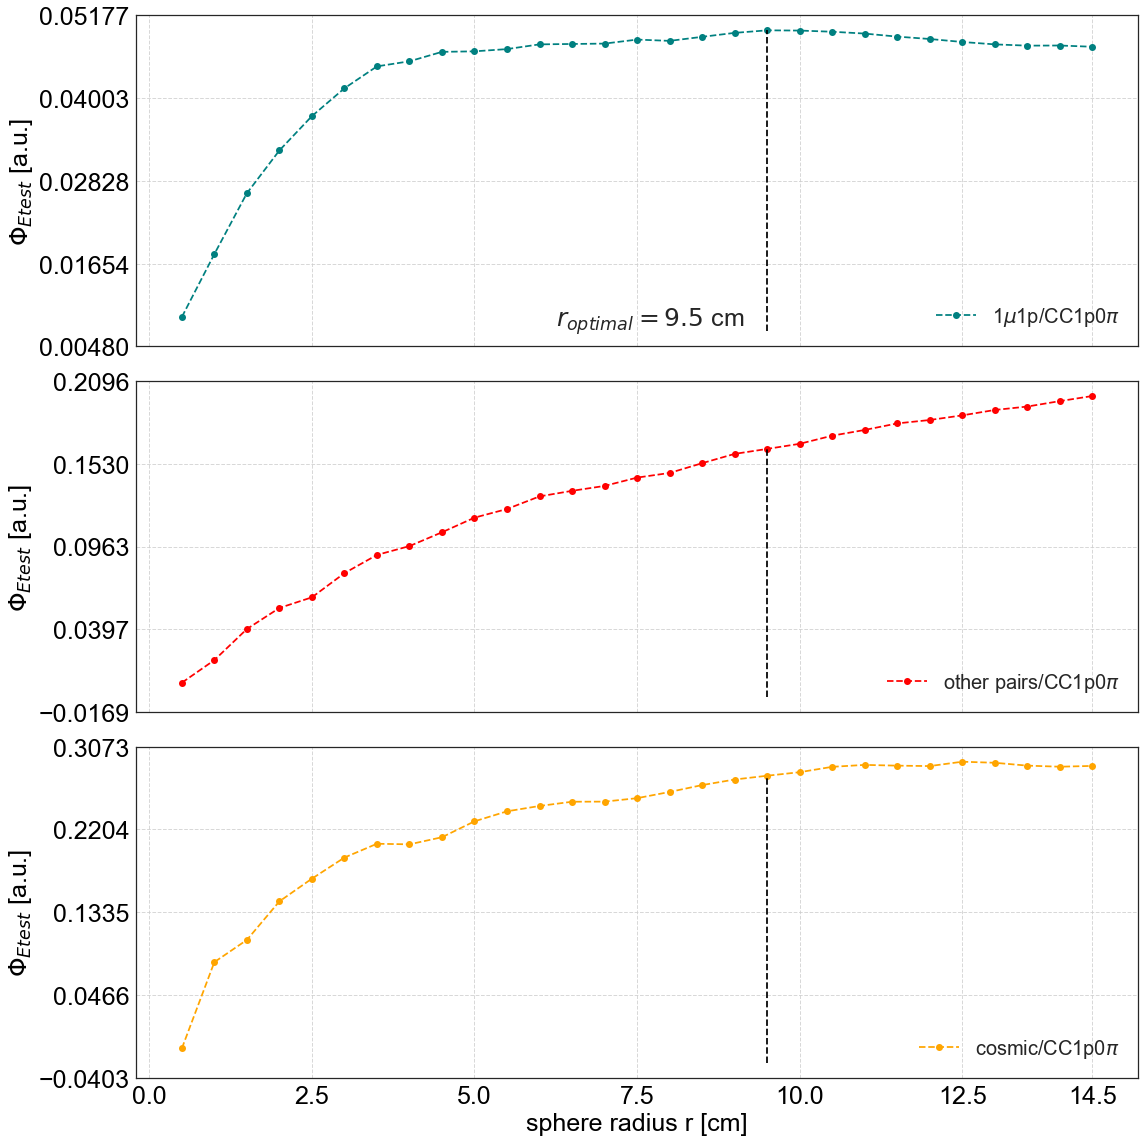

In [62]:
xticks=[0,5,10,15,20,25,29] 
fig=plt.figure(figsize=(16,16))
i_max=0
r_max=0
for i_pair_type in range(3):
    ax = fig.add_subplot(3,1,i_pair_type+1)
    pair_type=pair_types[i_pair_type];color=MCcolors[i_pair_type];label=MClabels[i_pair_type]
    y = pd_Etest_results[pair_type+'/'+'CC 1p 0pi'];
    plt.plot( y , '--o' , color=color , label=label+'/CC1p0$\pi$')
    leg=plt.legend(fontsize=20,loc='lower right')#,bbox_to_anchor=(1.05,1),loc=2
    set_axes( ax , 'sphere radius r [cm]' if i_pair_type==2 else ''
             , '$\Phi_{Etest}$ [a.u.]',xticks=xticks ,do_add_grid=True)
    ax.yaxis.set_major_locator(LinearLocator(5))

    tick_labels = [item.get_text() for item in ax.get_xticklabels()]
    for i,i_r_around_vertex in enumerate(xticks):
          tick_labels[i] = '%.1f'%(r_around_vertex[i_r_around_vertex]) if i_pair_type==2 else ''
    ax.set_xticklabels(tick_labels, rotation=0);
#     ax.xaxis.labelpad = -75
    
    # What is the optimal size?
    if i_pair_type==0:
        i_max = np.argmax(y)
        print 'i_max:',i_max
        r_max = r_around_vertex[i_max]
        plt.text(i_max-6.5,0.15*np.max(ax.get_ylim()),'$r_{optimal}=%.1f$ cm'%r_max,fontsize=25)
    plt.plot([i_max,i_max],[np.min(ax.get_ylim()),y[i_max]],'--',color='black')

    
plt.tight_layout()
plt.savefig(figures_path+'EtestPsi_vs_sphere_radius_after_detection_cuts.pdf',bbox_extra_artists=(leg,), bbox_inches='tight')